# Predicting Solar Irradiance Using Weather Features
Nicholas Carr, April 9, 2025. Introduction to Machine Learning: Supervised Learning Final Project
 Github: https://github.com/nmc-33/SolarPowerPredictor/blob/main/ML1%20Final.ipynb

## Project Topic
Solar power companies want to maximize their profits - in doing so, they need to determine when they should be producing solar energy, when it should be stored, and the volumes they should be targeting. Solar energy is highly variable, and depends on both the season, as well as the local weather. Understanding how local weather impacts the efficieny of a solar array is very helpful for this optimization. It has applications in energy estimation for solar arrays, energy management strategies, as well as for prospective site assessment. To that end, the problem that will be explored is how the Global Horizontal Irradiance (a measure of solar irradiance) is affeted by local weather features and time of day. Solar irradiance is proportional to the energy output from solar energy generation, and is readily available in the NREL dataset, so will be used as a proxy for solar energy output. 

The supervised learning regression algorithms of decision trees, random forest, and adaboost will be used to produce models relating GHI and local weather factors.

## Data
Data is from the publicly available United States National Renewable Energy Laboratory's National Solar Radiation Database. Data is tabulated. The are 15 features which are Year, Month, Day, Hour, Minute, Temperature, Cloud Type, Cloud Fill Flag, GHI, Ozone, Relative Humidity,  Wind Direction, Wind Speed, Pressure, and Precipitable Water. Year, Month, Day, Hour, and Minute are temporal data. Cloud Type and Cloud Fill Flag are ordinal - the higher the number, the more cloud cover there is. GHI, Ozone, Relative Humidity, Wind Direction, Wind Speed, Pressure, and Precipitable Water are ratio. Data is collected every hour, every day, over the past five years from the weather station + solar monitoring stations in Boulder. As such, there are 43,800 rows in the tabulated data.

National Renewable Energy Laboratory (NREL). (2023). National Solar Radiation Database (NSRDB). U.S. Department of Energy. https://nsrdb.nrel.gov/

In [9]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:

# List all CSV files in the current directory
csv_files = [f for f in os.listdir('.') if f.endswith('.csv')]

# Read and concatenate all CSV files, skipping the first 2 rows
df = pd.concat(
    (pd.read_csv(os.path.join('.', file), skiprows=2) for file in csv_files),
    ignore_index=True
)

print(df.head())

   Year  Month  Day  Hour  Minute  Temperature  Cloud Type  Cloud Fill Flag  \
0  2019      1    1     0      30        -12.6           7                0   
1  2019      1    1     1      30        -13.3           7                0   
2  2019      1    1     2      30        -13.8           7                0   
3  2019      1    1     3      30        -14.2           7                0   
4  2019      1    1     4      30        -14.5           7                0   

   GHI  Ozone  Relative Humidity  Wind Direction  Wind Speed  Pressure  \
0    0  0.363              55.93              33         3.4       823   
1    0  0.363              57.06              39         3.1       823   
2    0  0.363              57.40              46         2.8       823   
3    0  0.363              57.48              51         2.4       824   
4    0  0.363              57.93              54         2.2       824   

   Precipitable Water  
0                 0.3  
1                 0.3  
2       

## Data Cleaning

The data from the NREL database is mostly clean. However, there are a few issues that need to be handled. There are a handful of days that are missing values for some parameters. As the number of these is relatively small, I have elected to drop these values. 

Exploring the features, almost all features have very strong central tendencies, with a handful of outlier points. To prevent these from negatively impacting the model, the bottom and top 5% of the range have also been dropped from the dataset. 

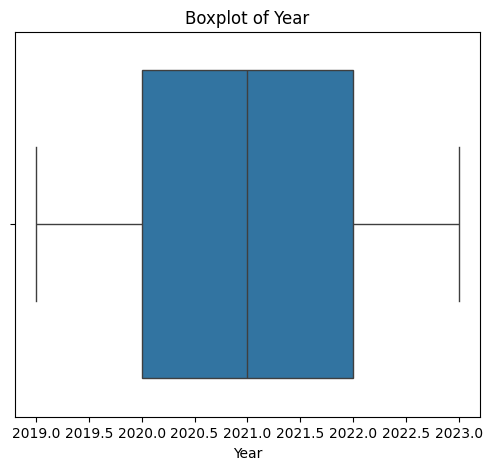

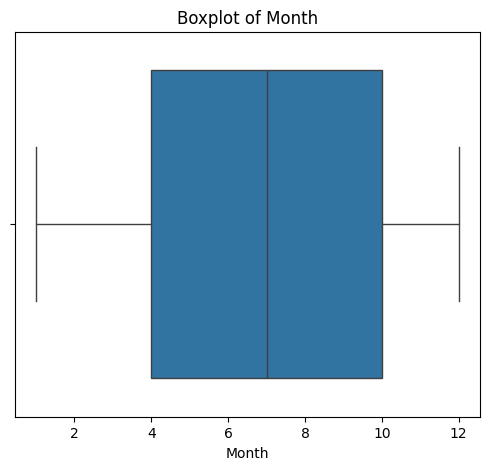

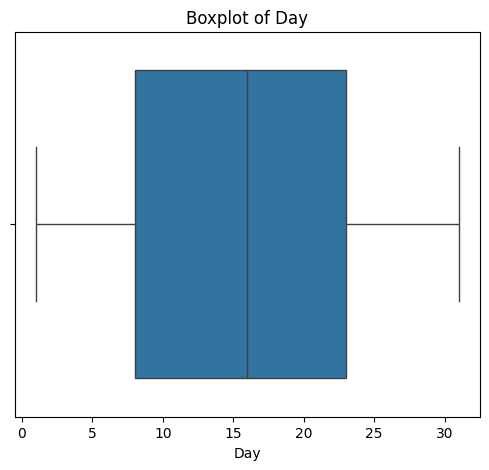

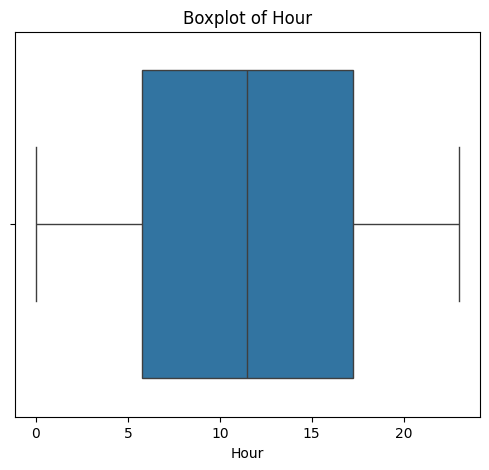

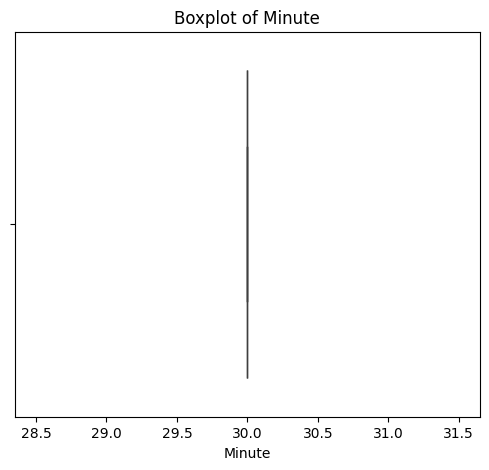

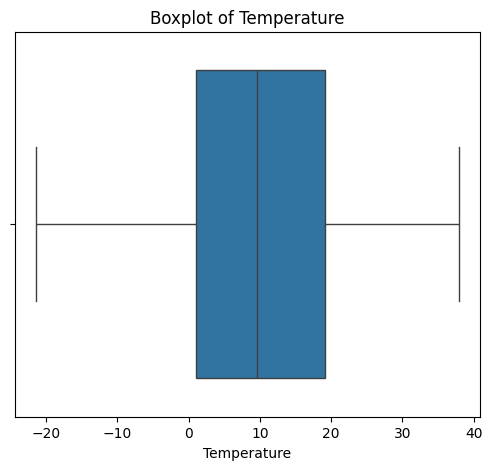

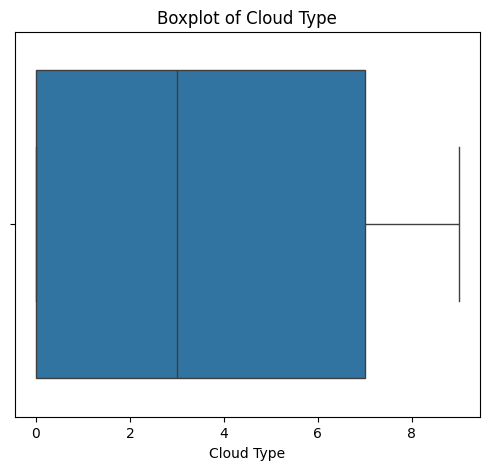

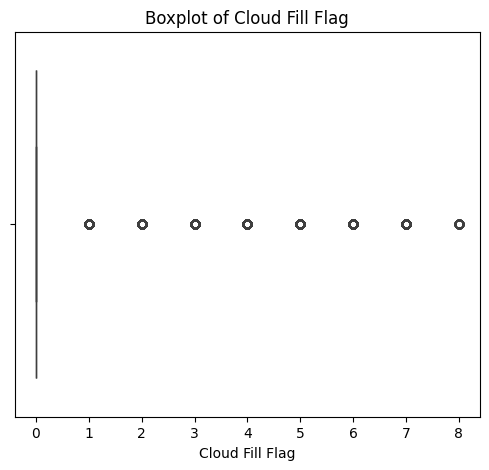

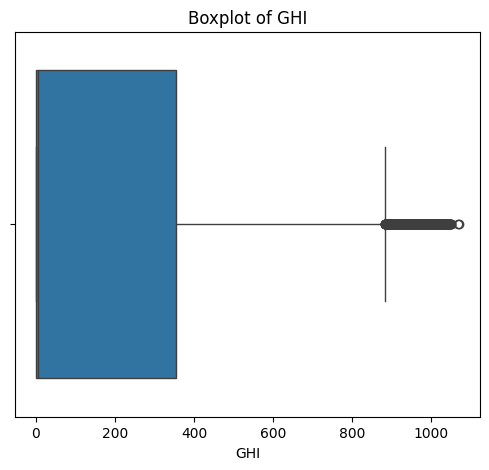

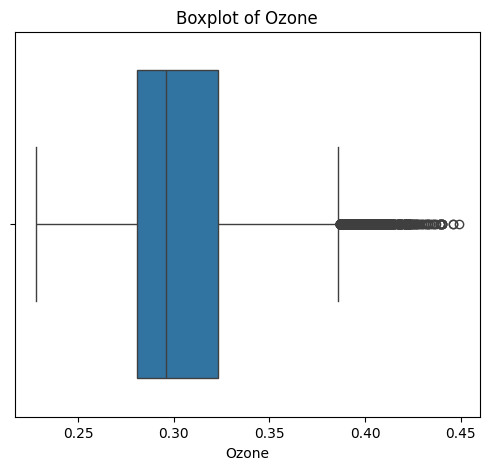

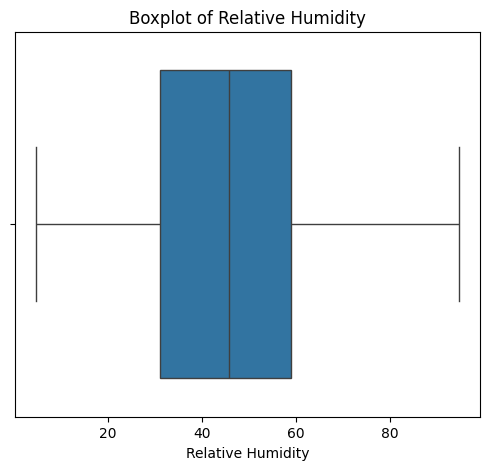

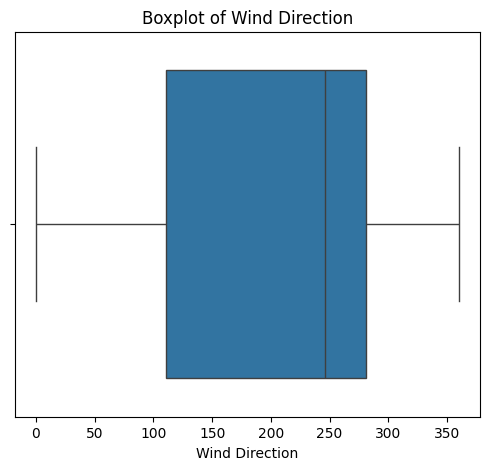

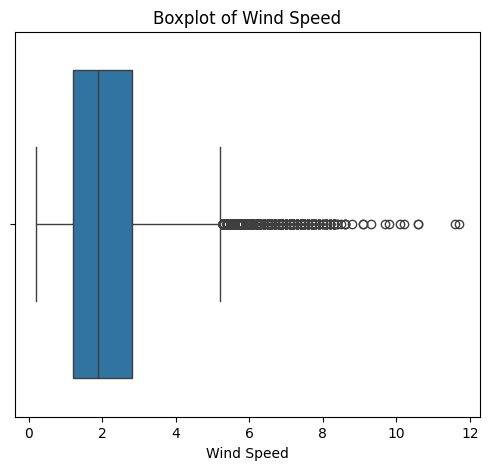

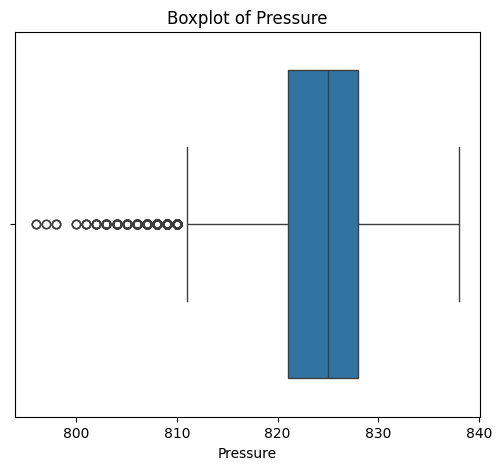

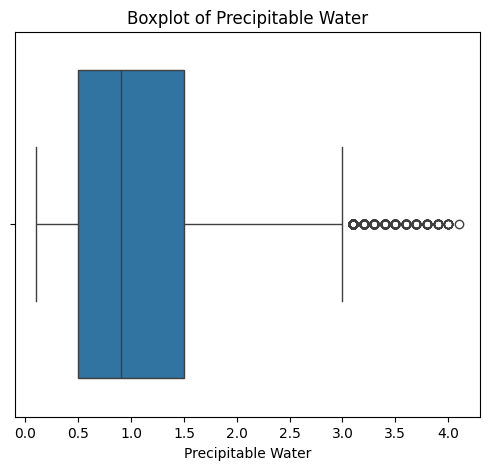

In [36]:
df.dropna(inplace = True)
factors = df.columns
for factor in factors:
    plt.figure(figsize=(6, 5))
    sns.boxplot(x=df[factor])
    plt.title(f"Boxplot of {factor}")
    plt.show()

LB = df[factors].quantile(0.05)
UB = df[factors].quantile(0.95)
Useful_Range = UB - LB
outlier_condition = ((df[factors] < (LB)) | (df[factors] > (UB)))
df_cleaned = df[~outlier_condition.any(axis=1)]  # Remove rows with outliers
df = df_cleaned

## Exploratory Data Analysis

Exploratory Data Analysis demonstrated that the strongest factors that relate weather to GHI were temperature, hour of the day, and relative humidity. Suprisingly, cloud cover and windspeeds, which seem like they would have a large impact on the incident radiation, were not the most strong predictors of GHI. Temperature likely functions as a proxy for the season of the year, which strongly impacts the level of solar radiation incident on the surface. As the sun's cycle has roughly the same peaks day to day, the hour of the day being correlated with the GHI makes sense as a strong predictor. Additionally, relative humidity was a more suprising variable, as it does not seem as though this should have a strong impact on solar radiation, but there is a strong negative correlation. A hypothesis as to why this occurs is that suspended water droplets in the air may refract the sun's light, making the incident radiation more diffuse.

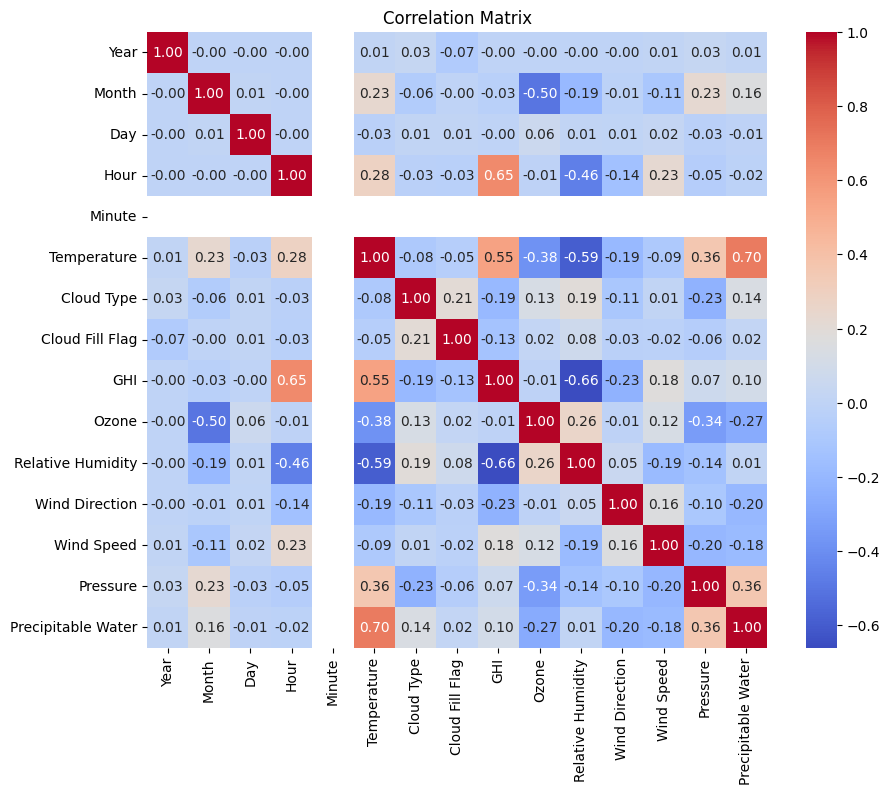

In [12]:
numeric_cols = df.select_dtypes(include=[np.number])
corr = numeric_cols.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Looking at this correlation matrix, the only features that have a strong correlation with GHI and are of a similar magnitude are Hour with 0.65, relative humidity at -0.66, and temperature, with 0.55. All other features are distinct, with the nearest correlation as low as 0.23, indicating that these 3 features are the strongest predictors for GHI by far.

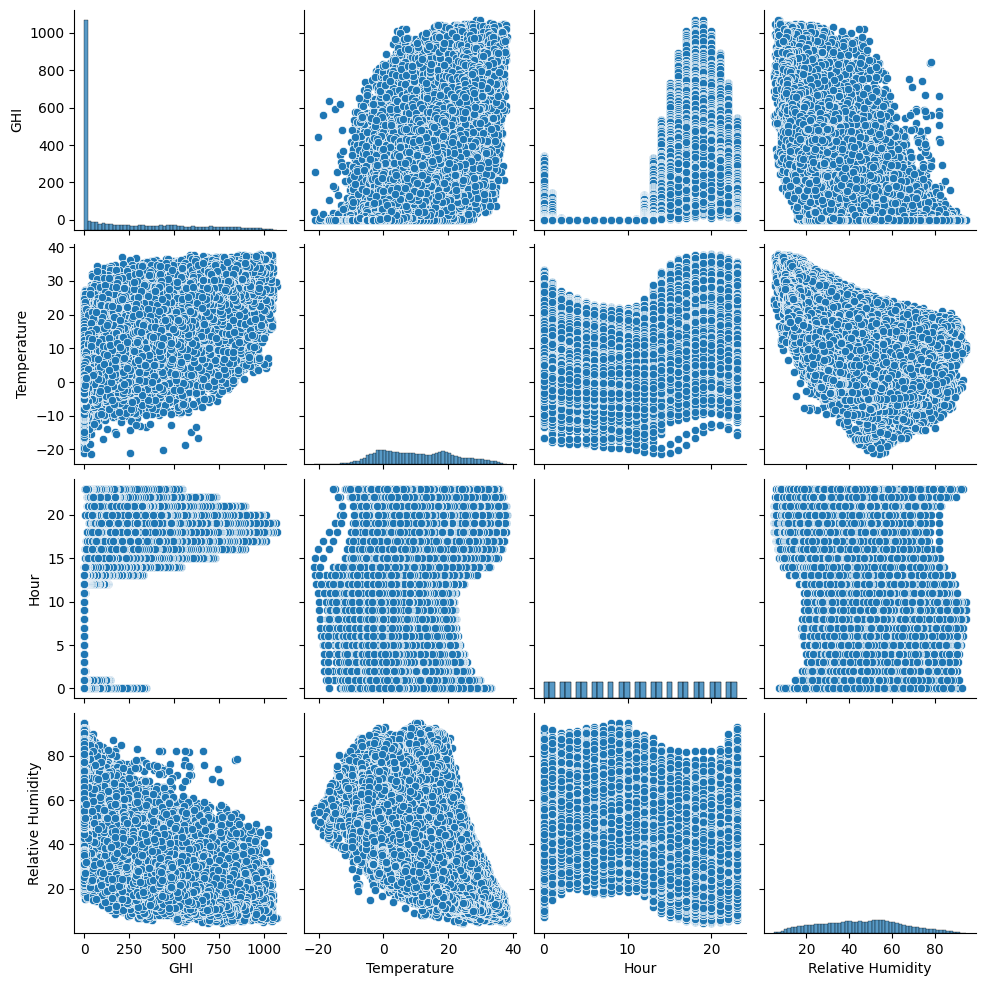

In [ ]:
attributes = ['GHI','Temperature', 'Hour', 'Relative Humidity']
sns.pairplot(df[attributes])

Note: Hours are measured in UTC and Colorado is -7, which is why the peak for GHI shows up at 19, rather than ~12, as we might expect.

## Models

The features of temperature, hour, and relative humidity are not multilinear or collinear, as can be seen in the pairplots above. 

This analysis will use Decision Trees, Random Forest, and AdaBoost. 

Hyperparameter tuning using GridSearchCV will also be implemented.

In [22]:
from sklearn.model_selection import train_test_split

attributes = ['Temperature', 'Hour', 'Relative Humidity']

X = df[attributes]
y = df['GHI']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=42)
param_grid_dt = {
    'max_depth': [1, 3, 10, 100],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}


grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, cv=3, error_score='raise')
grid_search_dt.fit(X_train, y_train)

best_params_dt = grid_search_dt.best_params_
best_score_dt = grid_search_dt.best_score_
print("Best parameters for Decision Tree:", best_params_dt)
print("Best cross-validation score for Decision Tree:", best_score_dt)


dt_best = grid_search_dt.best_estimator_
y_pred_dt = dt_best.predict(X_test)

Best parameters for Decision Tree: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10}
Best cross-validation score for Decision Tree: 0.7726589918681889


In [28]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
param_grid_rf = {
    'n_estimators': [1, 3, 10, 100],
    'max_depth': [1, 3, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3)
grid_search_rf.fit(X_train, y_train)

# Get the best parameters and score
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_
print("Best parameters for Random Forest:", best_params_rf)
print("Best cross-validation score for Random Forest:", best_score_rf)

# Train the final model with the best parameters
rf_best = grid_search_rf.best_estimator_


Best parameters for Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation score for Random Forest: 0.799173944773442


In [29]:
from sklearn.ensemble import AdaBoostRegressor

boost = AdaBoostRegressor(random_state=42)

param_grid_boost = {
    'n_estimators': [1, 3, 10, 100],
    'learning_rate': [0.01, 0.03, 0.1, 1.0],
}


grid_search_boost = GridSearchCV(estimator=boost, param_grid=param_grid_boost, cv=3)

# Fit the model to find the best hyperparameters
grid_search_boost.fit(X_train, y_train)

# Get the best parameters and score
best_params_boost = grid_search_boost.best_params_
best_score_boost = grid_search_boost.best_score_

print("Best parameters for AdaBoost:", best_params_boost)
print("Best cross-validation score for AdaBoost:", best_score_boost)

# Train the final model with the best parameters
adaboost_best = grid_search_boost.best_estimator_


Best parameters for AdaBoost: {'learning_rate': 0.1, 'n_estimators': 100}
Best cross-validation score for AdaBoost: 0.7669259109092335


## Results and Analysis

Best Model:  Random Forest


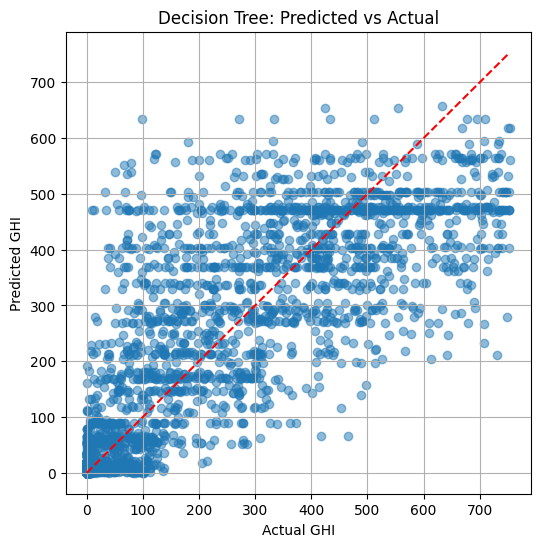

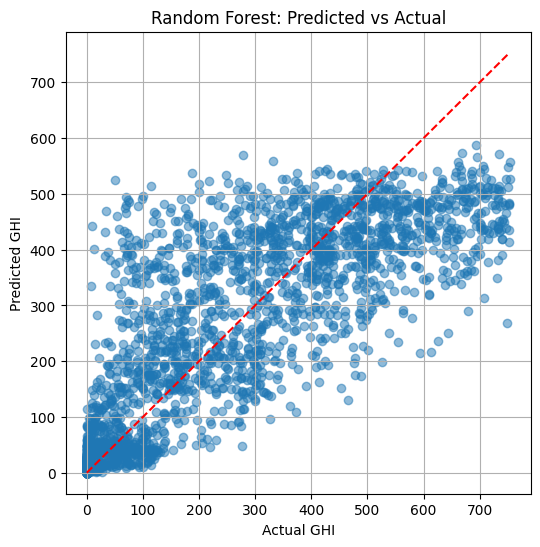

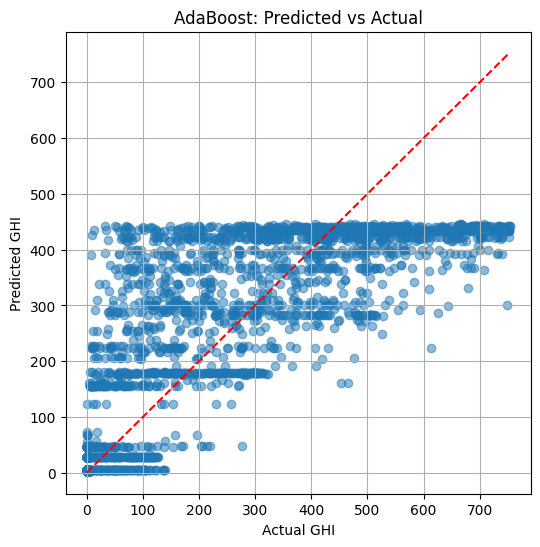

In [31]:
import matplotlib.pyplot as plt

def plot_preds(y_true, y_pred, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual GHI")
    plt.ylabel("Predicted GHI")
    plt.title(title)
    plt.grid(True)
    plt.show()

models = ['Decision Tree', 'Random Forest', 'AdaBoost']
best_index = np.argmax([best_score_dt, best_score_rf, best_score_boost])
best = models[best_index]
print("Best Model: " ,best)

plot_preds(y_test, dt_best.predict(X_test), "Decision Tree: Predicted vs Actual")
plot_preds(y_test, rf_best.predict(X_test), "Random Forest: Predicted vs Actual")
plot_preds(y_test, adaboost_best.predict(X_test), "AdaBoost: Predicted vs Actual")

Cross-validation error was used as the metric for comparison of these models, as it avoids overfitting, ensures all models use the same datasets and prevents splits from being ideal for one model type with it's sampling design. 

Three supervised learning models were trained on an 80/20 train/test split. Decision Trees, Random Forest, and Adaboost were used to create regressions to the training data. GridSearch CV was also used to optimize hyperparamters. Adaboost performed the worst of the lot. This is likely due to the variance in the training data - it's physical data so necessarily there is a high degree of variation day to day in weather patterns. When Adaboost in the classification setting misclassifies something, it gets a higher weight, which gives it more importance as time goes on. From the regression analog of this, it allows overfitting to the noisy data. Decision Trees performed second best, being less vulnerable to data noise, but still vulnerable to overfitting. Random forest performed best. The ensemble methods of random forest help it to both mitigate the impacts of noise and overfitting on the model, when the hyperparameters are properly tuned.

The improvements Random Forest offers over the decision tree are likely not worth the gain, as the fitting took substantially longer (8 minutes compared with 8 seconds for decision tree), but the gain in cross validation error was relatively small. To that end, the model that best balances the effort to results ratio is the decision tree.


## Discussions and Conclusions

This project explored using supervised learning to predict GHI based on weather data from the NREL Solar Radiation and Weather Information dataset. The dataset has several weather features, like windspeed, dew point, cloud type, as well as time features, like day of the month, month, and year, which were all reasonable to assume would be linked to solar irradiance. However, from the correlation analysis, the most important features were found to be temperature, hour, and relative humidity. Boxplot analysis revealed very centrally located data for these features, so the top/bottom 5% of the data was removed to prevent outliers from impacting the fits. Missing datapoints were minimal in the NREL dataset and were dropped to prevent them from impacting the models. 

The primary takeaway from this process was that the current modelling approaches employed here are not robust enough to predict solar energy, but they do give a good idea of the general trend, so there is room for further work in this space. Something that did not work as well as expected was the AdaBoost model. It's possible the hyperparameters selected did not give enough of a range to land on the optimal solution, as it ended up being worse than the decision tree fit, which was unexpected. Ways to improve this would be different hyperparameters, a finer search grid, or more robust noise cleanup within the data. Ways to improve all models would be using different training data - using only data at peak production hours might have stronger trends with local weather, using different supervised learning models, and using more features. It's possible that the interaction of some less-strongly correlated features with other features might result in a more robust understanding of the way local weather impacts